#**Microbe Mapper**                  **🦠**
##**Visual Recognition of Micro-organisms**

In [2]:
!pip install -q kaggle

In [3]:
#create the kaggle directory
!mkdir ~/.kaggle

In [4]:
#copying .json file to folder
!cp kaggle.json ~/.kaggle

In [5]:
#API command from kaggle
!kaggle datasets download -d mdwaquarazam/microorganism-image-classification

 74% 75.0M/101M [00:00<00:00, 118MB/s]
100% 101M/101M [00:00<00:00, 138MB/s] 


In [6]:
!unzip /content/microorganism-image-classification.zip

Archive:  /content/microorganism-image-classification.zip
  inflating: Micro_Organism/Amoeba/Image_1.jpg  
  inflating: Micro_Organism/Amoeba/Image_10.jpg  
  inflating: Micro_Organism/Amoeba/Image_11.jpg  
  inflating: Micro_Organism/Amoeba/Image_14.jpg  
  inflating: Micro_Organism/Amoeba/Image_16.jpg  
  inflating: Micro_Organism/Amoeba/Image_17.jpg  
  inflating: Micro_Organism/Amoeba/Image_19.jpg  
  inflating: Micro_Organism/Amoeba/Image_2.jpg  
  inflating: Micro_Organism/Amoeba/Image_20.png  
  inflating: Micro_Organism/Amoeba/Image_21.jpg  
  inflating: Micro_Organism/Amoeba/Image_22.jpg  
  inflating: Micro_Organism/Amoeba/Image_23.jpg  
  inflating: Micro_Organism/Amoeba/Image_24.jpg  
  inflating: Micro_Organism/Amoeba/Image_25.jpg  
  inflating: Micro_Organism/Amoeba/Image_26.jpg  
  inflating: Micro_Organism/Amoeba/Image_27.jpg  
  inflating: Micro_Organism/Amoeba/Image_28.jpg  
  inflating: Micro_Organism/Amoeba/Image_30.jpg  
  inflating: Micro_Organism/Amoeba/Image_31.

In [2]:
# making all necessary imports

import os
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import plotly.express as px
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout
from keras.callbacks import EarlyStopping as ES, ModelCheckpoint as MC
from tensorflow.keras.applications import ResNet50V2, ResNet50, InceptionV3, Xception
from matplotlib import RcParams
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'keras'

In [8]:
gen = ImageDataGenerator(rescale=1./255, rotation_range=10, horizontal_flip=True, brightness_range=[0.3,0.8], validation_split=0.1)

In [9]:
train_ds= gen.flow_from_directory(
    '/content/Micro_Organism/',
    batch_size=128,
    shuffle=True,
    class_mode='binary',
    target_size=(256,256),
    subset='training'
)
valid_ds= gen.flow_from_directory(
    '/content/Micro_Organism/',
    batch_size=64,
    shuffle=True,
    class_mode='binary',
    target_size=(256,256),
    subset='validation'
)


Found 714 images belonging to 8 classes.
Found 75 images belonging to 8 classes.


In [10]:
class_names = sorted(os.listdir('/content/Micro_Organism/'))
n_classes = len(class_names)
print('class_names: ',class_names)
print('number_of_classes: ',n_classes)

class_names:  ['Amoeba', 'Euglena', 'Hydra', 'Paramecium', 'Rod_bacteria', 'Spherical_bacteria', 'Spiral_bacteria', 'Yeast']
number_of_classes:  8


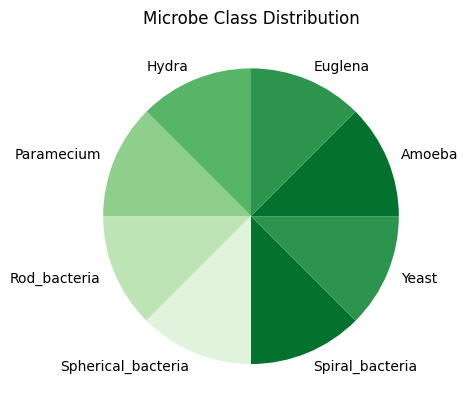

In [11]:
# fig = px.pie(names=class_names, title="Class Distribution")
# fig.update_layout({'title':{'x':0.45}})
# fig.show()

# plt.pie(names=class_names, labels=class_names)
# plt.title("Class Distribution", loc="center", pad=20)
# plt.show()
sns.set_palette('Greens_r')
plt.pie([1] * len(class_names), labels=class_names)
plt.title("Microbe Class Distribution", loc="center")
plt.show()

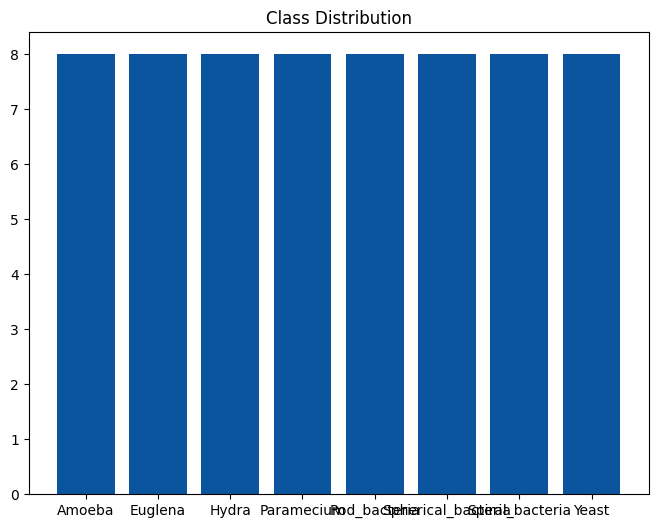

In [12]:
sns.set_palette('Blues_r')
plt.figure(figsize=(10, 6))
plt.bar(class_names, n_classes)
plt.title("Class Distribution")

# Show the plot
plt.show()

In [13]:
def show_images(data, GRID=[2,6], model=None, size=(25,10)):

    # The plotting configurations
    n_rows, n_cols = GRID
    n_images = n_rows * n_cols
    plt.figure(figsize=size)

    # Data for visualization
    images, labels = next(iter(data)) # This process can take a little time because of the large batch size

    # Iterate through the subplots.
    for i in range(1, n_images+1):

        # Select a random data
        id = np.random.randint(len(images)) # This is a dynamic function because for validation data and training data, the length of total images is different.
        image, label = images[id], class_names[int(labels[id])]

        # Plot the sub plot
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        plt.axis('off')
        # If model is available make predictions.
        if model is not None:
            pred = class_names[np.argmax(model.predict(image[np.newaxis,...]))]
            title = f"Class : {label}\nPred : {pred}"
        else:
            title = f"Class : {label}"

        plt.title(title)
    plt.show()

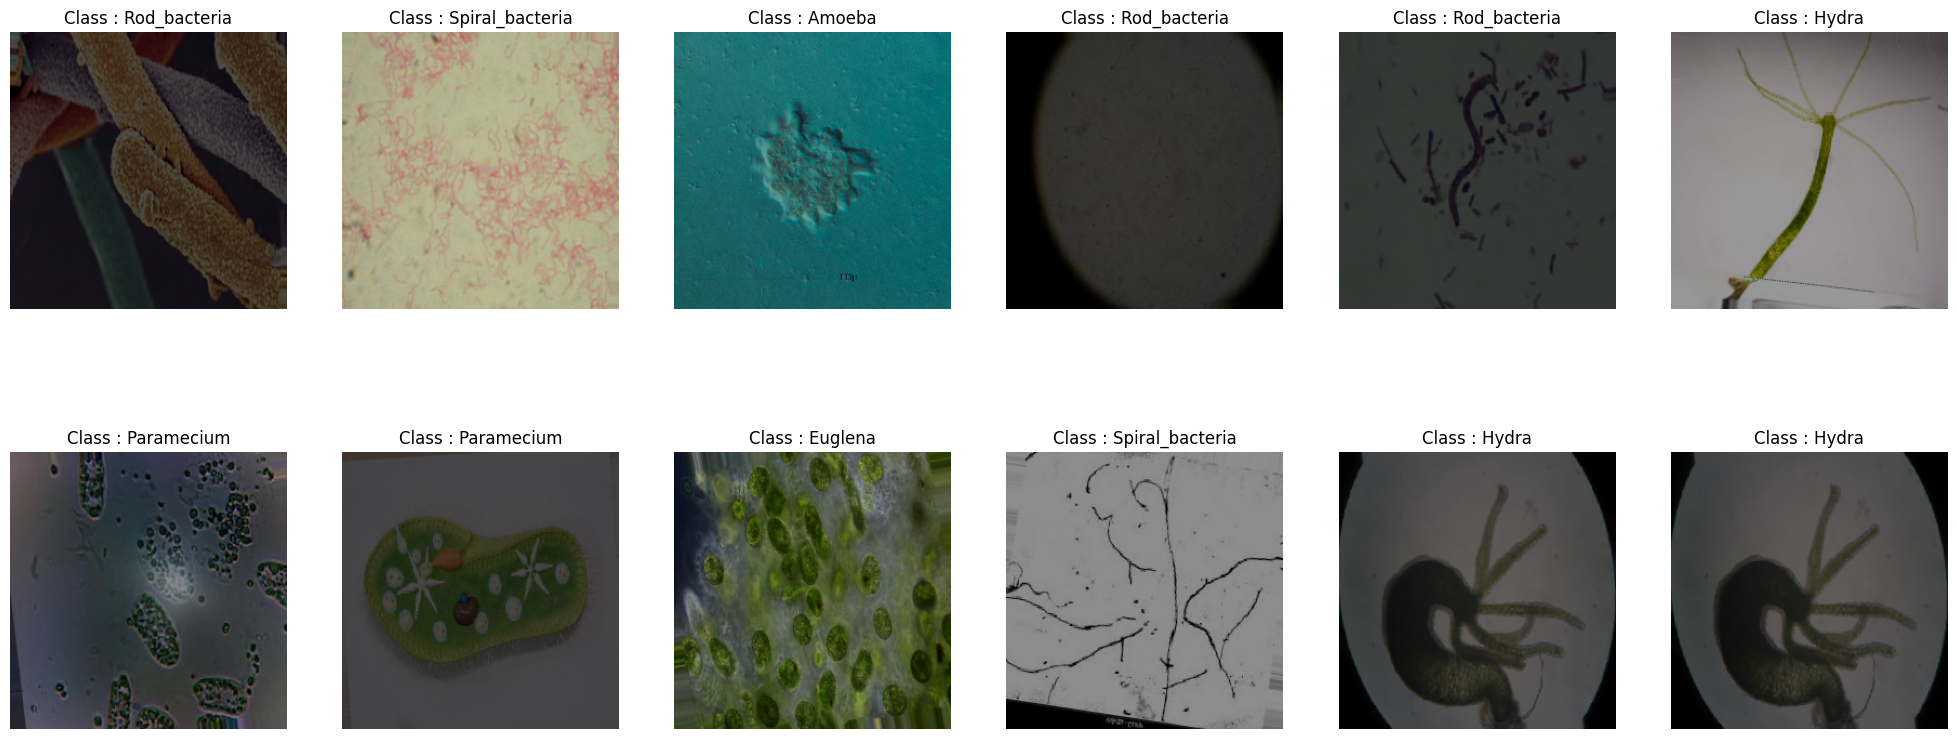

In [14]:
show_images(data=train_ds)

In [15]:
# Give you a model, a name
name = "inception-v3"

# Base model
base = InceptionV3(input_shape=(256,256,3), include_top=False)
base.trainable = False

# Model Architecture
model = Sequential([
    base, GAP(),
    Dense(256, kernel_initializer='he_normal', activation='relu'),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
])

# Callbacks
cbs = [ES(patience=3, restore_best_weights=True), MC(name + ".h5", save_best_only=True)]

# Compile Model
opt = tf.keras.optimizers.Adam(learning_rate=1e-3) # Higher than the default learning rate 1e-3
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Training
history = model.fit(train_ds, validation_data=valid_ds, epochs=50, callbacks=cbs)

87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/50
6/6 [==============================] - 43s 4s/step - loss: 2.3698 - accuracy: 0.2101 - val_loss: 1.6713 - val_accuracy: 0.3867
Epoch 2/50
6/6 [==============================] - 25s 4s/step - loss: 1.6406 - accuracy: 0.4272 - val_loss: 1.3934 - val_accuracy: 0.5067
Epoch 3/50
6/6 [==============================] - 22s 3s/step - loss: 1.2546 - accuracy: 0.5952 - val_loss: 1.2651 - val_accuracy: 0.6267
Epoch 4/50
6/6 [==============================] - 21s 3s/step - loss: 1.0707 - accuracy: 0.6625 - val_loss: 1.0814 - val_accuracy: 0.6133
Epoch 5/50
6/6 [==============================] - 18s 3s/step - loss: 0.9312 - accuracy: 0.6863 - val_loss: 1.1289 - val_accuracy: 0.6000
Epoch 6/50
6/6 [==============================] - 22s 4s/step - loss: 0.8170 - accuracy: 0.7269 - val_loss: 1.0833 - val_accuracy: 0.6400
Epoch 7/50
6/6 [==============================] - 20s 3s/step - loss: 0.7743 - accuracy: 0.7479 - val_loss:

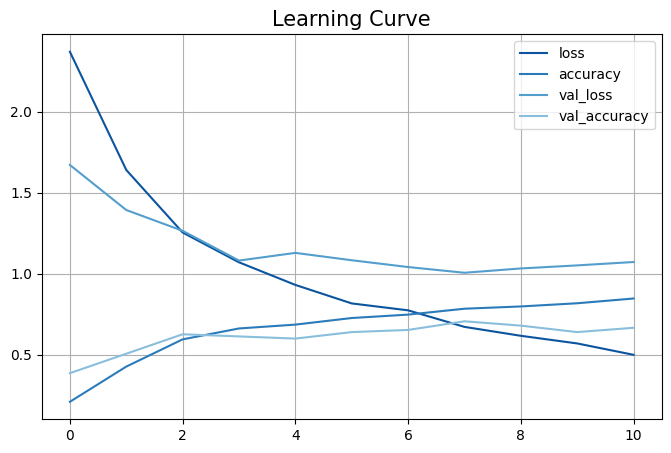

In [16]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.title("Learning Curve", fontsize=15)
plt.grid()
plt.show()

1/1 [==============================] - 0s 25ms/step


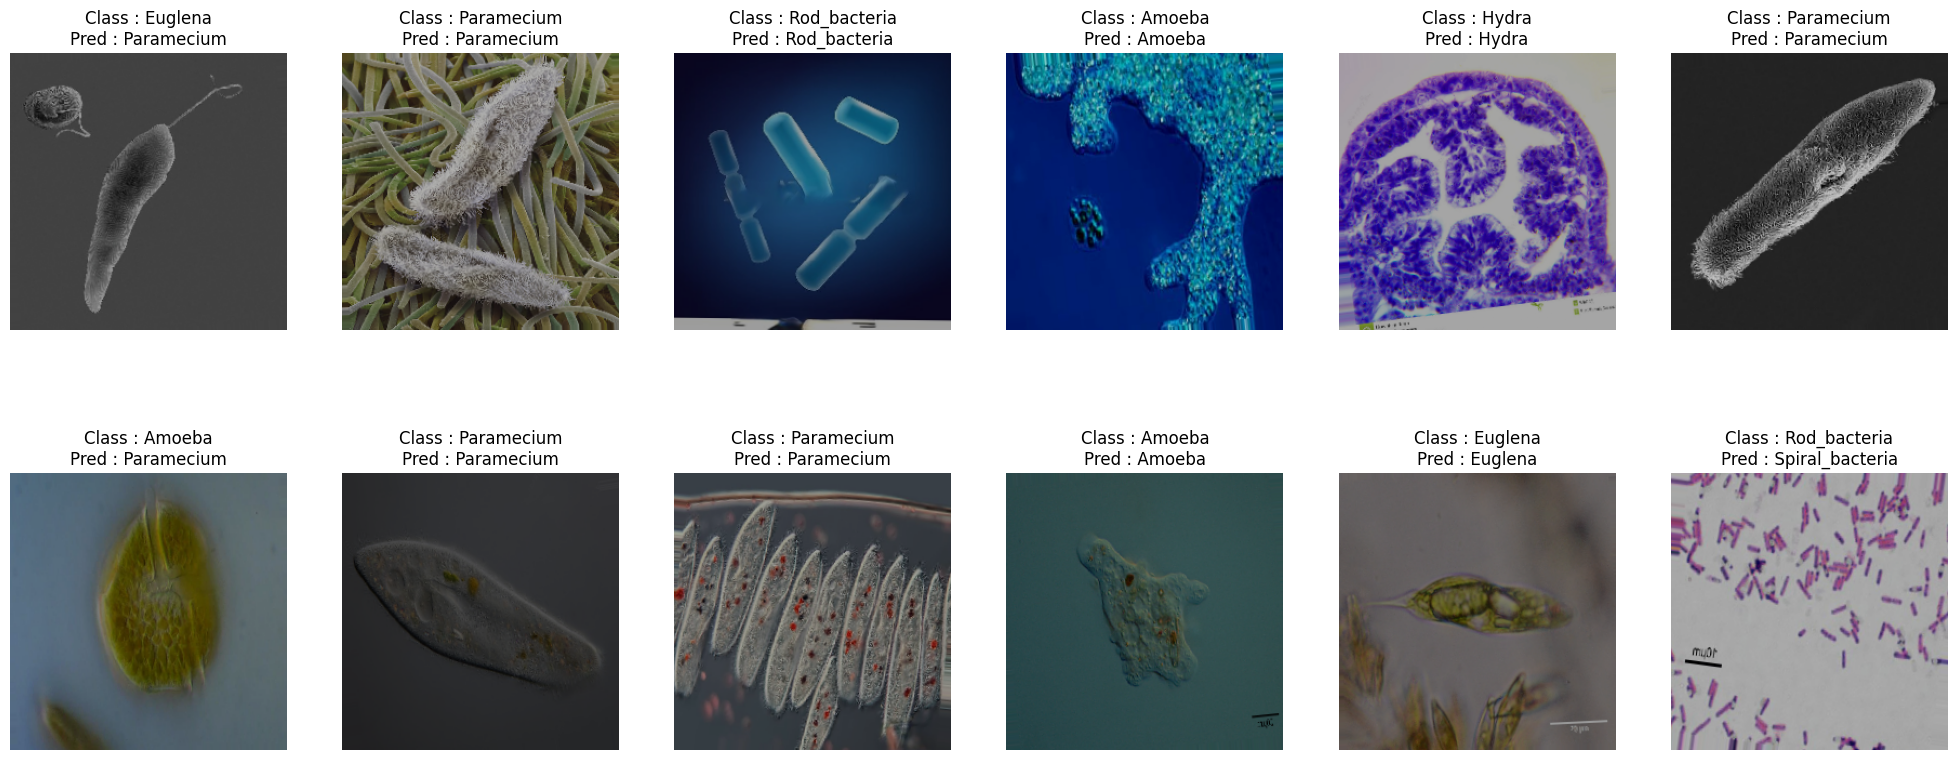

In [17]:
show_images(data=valid_ds, model=model)

In [18]:
from tensorflow.keras.applications import InceptionV3

# Load the InceptionV3 model
model = InceptionV3()

# Access the layers of the model
layers = model.layers

# Print the names of the layers
c=0
for layer in layers:
    print(layer.name)
    c+=1
print(c)

96112376/96112376 [==============================] - 2s 0us/step
input_2
conv2d_94
batch_normalization_94
activation_94
conv2d_95
batch_normalization_95
activation_95
conv2d_96
batch_normalization_96
activation_96
max_pooling2d_4
conv2d_97
batch_normalization_97
activation_97
conv2d_98
batch_normalization_98
activation_98
max_pooling2d_5
conv2d_102
batch_normalization_102
activation_102
conv2d_100
conv2d_103
batch_normalization_100
batch_normalization_103
activation_100
activation_103
average_pooling2d_9
conv2d_99
conv2d_101
conv2d_104
conv2d_105
batch_normalization_99
batch_normalization_101
batch_normalization_104
batch_normalization_105
activation_99
activation_101
activation_104
activation_105
mixed0
conv2d_109
batch_normalization_109
activation_109
conv2d_107
conv2d_110
batch_normalization_107
batch_normalization_110
activation_107
activation_110
average_pooling2d_10
conv2d_106
conv2d_108
conv2d_111
conv2d_112
batch_normalization_106
batch_normalization_108
batch_normalization_111

In [19]:
model.save('microbeclassification.h5')

In [20]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 149, 149, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 149, 149, 32)         0         ['batch_normalizati

####**Testing the Model with a sample image**

1/1 [==============================] - 1s 1s/step


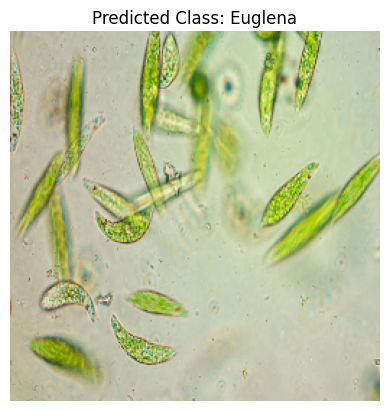

In [24]:
from keras.preprocessing import image
import numpy as np

# Load the trained InceptionV3 model
model = load_model("inception-v3.h5")  # Make sure to use the correct path if it's saved in a different directory

# Load and preprocess the test image
img_path = '/content/Image_20.jpeg'  # Replace with the path to your test image
img = image.load_img(img_path, target_size=(256, 256))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255.0  # Normalize the pixel values

# Make a prediction
predictions = model.predict(x)

# Decode the predictions
class_names = sorted(os.listdir('/content/Micro_Organism/'))
predicted_class = class_names[np.argmax(predictions)]

# Print the predicted class
plt.imshow(img)
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')
plt.show()


In [27]:
#Download the model as a pickle file

import pickle
pickle.dump(model,open('microbemapper.pkl','wb'))
